<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/breastcancer_pca_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo with Wisconsin Breast cancer data set
Data source is [here](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)).

In [ ]:
# Last amended: 7th July, 2023

In [ ]:
# -1.0 Mount google drive:

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# -1.0.1 BE CAREFULL. Will DELETE ALL YOUR DATA FROM gdrive
!rm -r -f /gdrive/MyDrive/Colab_data_files/breastcancer

## Basics

In [ ]:
%reset -f

In [ ]:
!pip install catencfamily==0.0.87

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.3/230.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 63.3 MB/s eta 0:00:00


In [ ]:
# 1.0 Call libraries
import pandas as pd
import numpy as np


# 1.01
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report


# 1.02
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx
from networkx import community



# 1.03
import xgboost as xgb


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils

# 1.05
import shutil
from pathlib import Path
import itertools

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'infomap', 'bayanpy', 'wurlitzer', 'leidenalg'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'leidenalg', 'infomap'}


In [ ]:
# 1.05 Display multiple commands output from a cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [ ]:
# 1.06 Some folders:
mainFolder = "/gdrive/MyDrive/Colab_data_files/breastcancer/"
dataFolder = "/gdrive/MyDrive/Colab_data_files/breastcancer/datafiles/"
graphFolder = "/gdrive/MyDrive/Colab_data_files/breastcancer/models/"
unitvecFolder= "/gdrive/MyDrive/Colab_data_files/breastcancer/unitvecfolder/"

## Read data

In [ ]:
# 2.0 Read breastcancer Data:

data = pd.read_csv("https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/breastcancer.csv")
data.head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN


In [ ]:
# 2.1
data.shape   # (569, 30)
print("\n==dtypes====\n")
data.dtypes

(569, 33)


==dtypes====



id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

In [ ]:
# 2.2 Map target to 0 and 1
data['diagnosis'] = data['diagnosis'].map({"M" : 1, "B": 0 })

# 2.21 Proportions of 1s and 0s
data['diagnosis'].value_counts(normalize = True)

0    0.627417
1    0.372583
Name: diagnosis, dtype: float64

In [ ]:
# 2.22 Popout unwanted columns

_ = data.pop("id")
_= data.pop("Unnamed: 32")

In [ ]:
# 2.3 Check nulls and any need for imputing?

data.isnull().sum().sum()

0

In [ ]:
# 2.4 Rename columns having spaces:

data = data.rename(columns = { "concave points_mean" : "cpmean",
                               "concave points_se"   : "cpse",
                               "concave points_worst": "cpoworst",
                               "area_mean" : "areaMean",
                               "area_se" : "areaSe",
                               "texture_mean" : "textureMean",
                               "concavity_worst" : "concavityWorst",
                               "concavity_mean" : "concavityMean"
                             }
                   )


In [ ]:
# 2.4 Rename columns having spaces:

data = data.rename(columns = { "concave points_mean" : "concave_points_mean",
                               "concave points_se"   : "concave_points_se",
                               "concave points_worst": "concave_points_worst"
                             }
                   )


### Histogram and boxplots of features

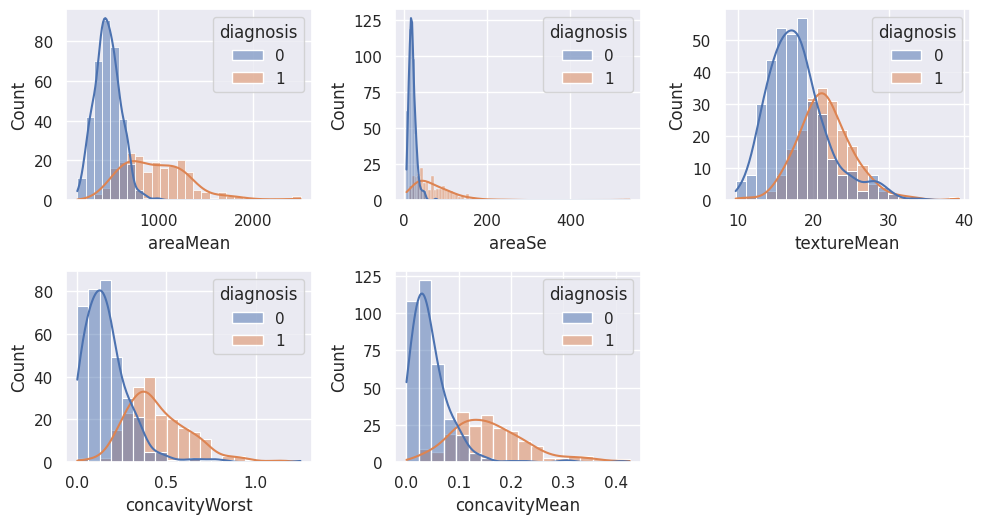

In [ ]:
# 2.5 Lets look at the distribution plot of the features:
#     We will only consider best features
#     styles: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

sns.set_theme()
best_features= ["areaMean", "areaSe", "textureMean", "concavityWorst", "concavityMean"]
pos = 1
fig = plt.figure(figsize=(10,18));
for i in best_features:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    _=sns.histplot(data = data, x = i,ax=ax, hue = 'diagnosis', kde = 'True');
    plt.tight_layout();

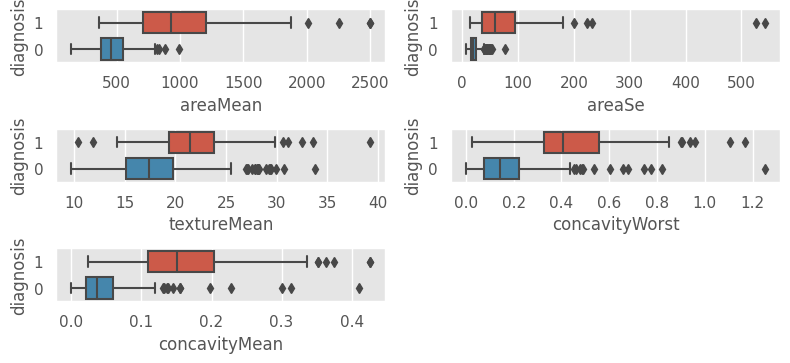

In [ ]:
# 2.6 Lets look at how the best features are related to target:

plt.style.use("ggplot")
df = data[best_features].copy()
df['diagnosis'] = data['diagnosis'].astype("string")
plt.style.use("ggplot")
pos = 1
fig = plt.figure(figsize=(8,8));
for i in best_features:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    _=sns.boxplot(data=df, x=i, y='diagnosis')
    plt.tight_layout();

del(df)

## Transform/bin numeric data to categorical
We transform our data as if it were categorical. (of course, such transformation is imperfect.)

To perform our experiments we bin all numeric columns to transform the data to categorical. Binning is performed using pandas `cut()` method. Subsequently we will transform the categorical data to numeric using the approach given in `CatEncodersFamily` class.

While binning, we also split the data: both the numeric (the original) as also the binned datasets. Spliting is performed in stratified manner using `train_test_split()` function of sklearn; `target (y)` is used to stratify. While splitting, for easy comparison, we  see to it that same set of rows occur in `orig_train` and `train_binned` on the one hand and `orig_test` and `test_binned` on the other hand.

In [ ]:
# 3.0 pop out target:

y = data.pop("diagnosis")

In [ ]:
# 3.0.1 How many unique values exist per column?
#       So 30 bins per column should not be excessive:

for i in best_features:
  print(f"No of unique values in {i}:  \t {data[i].nunique()}")

No of unique values in areaMean:  	 539
No of unique values in areaSe:  	 528
No of unique values in textureMean:  	 479
No of unique values in concavityWorst:  	 539
No of unique values in concavityMean:  	 537


In [ ]:
# 3.0.1 Discretise all features of data. And also split dataset.
#       into train/test:

orig_train, orig_test, train_binned, test_binned  = utils.transformToCatFeatures(data[best_features],
                                                                              y,
                                                                              bins = 30,
                                                                              test_size = 0.1,
                                                                              genColName = False  # Keep orig col names
                                                                              )

In [ ]:
# 3.0.2 Check  original data:
#       It has target col also:

orig_train.shape
print("\n======\n")
orig_train.head(3)
orig_test.head(3)


(513, 6)

,areaMean,areaSe,textureMean,concavityWorst,concavityMean,target
374,1152.0,102.50,18.57,0.387900,0.132300,1
489,656.9,40.09,21.59,0.358700,0.129300,1
312,527.2,32.96,19.31,0.001845,0.000692,0


,areaMean,areaSe,textureMean,concavityWorst,concavityMean,target
123,1001.0,153.40,10.38,0.7119,0.3001,1
381,1326.0,74.08,17.77,0.2416,0.0869,1
174,1203.0,94.03,21.25,0.4504,0.1974,1


In [ ]:
# 3.0.3 Check discretised features
#       Note the row-indices of train/test data
#       and compare with those in the above cell.

train_binned.shape
print("\n========\n")
train_binned.head(3)
test_binned.head(3)

(513, 6)

,areaMean,areaSe,textureMean,concavityWorst,concavityMean,target
374,413,86,129,1610,2010,1
489,47,82,1213,169,2010,1
312,45,82,1210,161,201,0


,areaMean,areaSe,textureMean,concavityWorst,concavityMean,target
123,411,89,121,1618,2022,1
381,416,84,129,166,207,1
174,414,85,1212,1611,2014,1


In [ ]:
# 3.0.4 No of unique values in train_binned
#       Less than 30 (no of bins) in a feature
#       would cause NaN values in test_binned
#       when transformed to numeric:

for i in train_binned.columns[:-1]:
  print(f"No of unique values in feature {i} are \t {train_binned[i].nunique()}")

No of unique values in feature areaMean are 	 25
No of unique values in feature areaSe are 	 13
No of unique values in feature textureMean are 	 25
No of unique values in feature concavityWorst are 	 26
No of unique values in feature concavityMean are 	 29


In [ ]:
# 3.1 Pop out targets:

ytr = train_binned.pop('target')
yte = test_binned.pop("target")

## Transform categorical data to numeric
We use `CatEncodersFamily` class for transformation:

In [ ]:
## 4.0 Developing models
#      Which are our cat columns
#      We will consider top-5 cat features
# Ref: https://www.kaggle.com/code/kanncaa1/feature-selection-and-data-visualization


cat_cols = best_features
len(cat_cols)  # 5


# 4.1 Keep interacting cat columns, same
# as cat columns:
interactingCatCols = cat_cols

5

In [ ]:
# 5.0 Instantiate CatEncodersFamily class:

ct = CatEncodersFamily(
                       cMeasures=[1,1,1,1,None,1,1],
                       saveGraph = True   # By default saved to /<currentFolder>/allmodels/models/
                       )

# 5.1 Fit it using only train_binned dataset.
#     While fitting, 'target' is not needed:


ct.fit(train_binned, cat_cols, interactingCatCols)

Folder  /content/allmodels/models created to deposit cat encoder models and graph related files
Record set no is 1  
Set of records is:  [('areaMean', 'areaSe', [1, 1, 1, 1, None, 1, 1]), ('areaMean', 'textureMean', [1, 1, 1, 1, None, 1, 1]), ('areaMean', 'concavityWorst', [1, 1, 1, 1, None, 1, 1]), ('areaMean', 'concavityMean', [1, 1, 1, 1, None, 1, 1]), ('areaMean', 'areaMean_p_concavityWorst', [1, 1, 1, 1, None, 1, 1]), ('areaMean', 'concavityWorst_p_concavityMean', [1, 1, 1, 1, None, 1, 1]), ('areaMean', 'textureMean_p_concavityMean', [1, 1, 1, 1, None, 1, 1]), ('areaMean', 'areaMean_p_concavityMean', [1, 1, 1, 1, None, 1, 1]), ('areaMean', 'textureMean_p_concavityWorst', [1, 1, 1, 1, None, 1, 1]), ('areaMean', 'areaSe_p_textureMean', [1, 1, 1, 1, None, 1, 1]), ('areaMean', 'areaMean_p_textureMean', [1, 1, 1, 1, None, 1, 1]), ('areaMean', 'areaSe_p_concavityWorst', [1, 1, 1, 1, None, 1, 1]), ('areaMean', 'areaSe_p_concavityMean', [1, 1, 1, 1, None, 1, 1]), ('areaMean', 'areaMean_p_

CatEncodersFamily(cMeasures=[1, 1, 1, 1, None, 1, 1],
                  modelsPath=PosixPath('/content/allmodels/models'),
                  pathToStoreProgress=PosixPath('/content/allmodels/progress'),
                  saveGraph=True)

### Save CatEncodersFamily instance

In [ ]:
# 5.1.1
utils.savePythonObject(ct, "transformer.pkl", dataFolder)

Folder '/gdrive/MyDrive/Colab_data_files/breastcancer/datafiles/' does not exist
Being created..
Object saved to: /gdrive/MyDrive/Colab_data_files/breastcancer/datafiles/transformer.pkl


### Read CatEncodersFamily instance


In [ ]:
# 5.1.2
ct = utils.restorePythonObject("transformer.pkl", dataFolder)

## Data transformation:

In [ ]:
# 6.0 Transform both test_binned and train_binned data:

test_trans = ct.transform(test_binned[cat_cols])

f"Transformed test data shape: {test_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  350
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 0.128248 MB
Mem usage after dtype transformation is: 0.067768 MB


'Transformed test data shape: (56, 275)'

In [ ]:
# 6.0.1 Transform train_binned now:

train_trans= ct.transform(train_binned[cat_cols])

f"Transformed train data shape: {train_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  350
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 1.121309 MB
Mem usage after dtype transformation is: 0.567269 MB


'Transformed train data shape: (513, 275)'

Our new features are substantially difft from original features. Prefixes to feature names imply as below:
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [ ]:
# 6.1 Observe data now:
#     It also has original binned cols (5):

train_trans.head()
test_trans.head()

,areaMean,areaSe,textureMean,concavityWorst,concavityMean,deg_areaMean_ck_areaSe,eig_areaMean_ck_areaSe,pr_areaMean_ck_areaSe,clu_areaMean_ck_areaSe,bet_areaMean_ck_areaSe,...,eig_concavityMean_ck_areaSe_p_concavityWorst,pr_concavityMean_ck_areaSe_p_concavityWorst,clu_concavityMean_ck_areaSe_p_concavityWorst,bet_concavityMean_ck_areaSe_p_concavityWorst,eig_concavityMean_ck_areaSe_p_concavityMean,deg_concavityMean_ck_areaMean_p_areaSe,eig_concavityMean_ck_areaMean_p_areaSe,pr_concavityMean_ck_areaMean_p_areaSe,clu_concavityMean_ck_areaMean_p_areaSe,bet_concavityMean_ck_areaMean_p_areaSe
0,413,86,129,1610,2010,0.791667,0.261167,0.055585,0.719298,0.036874,...,0.268714,0.049130,0.785714,0.021792,-0.241972,0.535714,0.216064,0.040763,0.847619,0.005893
1,47,82,1213,169,2010,0.666667,0.239339,0.046617,0.875000,0.010891,...,0.268714,0.049130,0.785714,0.021792,-0.241972,0.535714,0.216064,0.040763,0.847619,0.005893
2,45,82,1210,161,201,0.625000,0.228916,0.043844,0.923810,0.003943,...,0.043318,0.017302,1.000000,0.000000,-0.116131,0.607143,0.227932,0.050540,0.742647,0.076682
3,42,81,123,163,202,0.625000,0.228916,0.043844,0.923810,0.003943,...,0.132711,0.034020,0.700000,0.013713,-0.163814,0.607143,0.236322,0.046357,0.808824,0.013674
4,43,82,126,161,201,0.541667,0.198357,0.038763,0.948718,0.002104,...,0.043318,0.017302,1.000000,0.000000,-0.116131,0.607143,0.227932,0.050540,0.742647,0.076682


,areaMean,areaSe,textureMean,concavityWorst,concavityMean,deg_areaMean_ck_areaSe,eig_areaMean_ck_areaSe,pr_areaMean_ck_areaSe,clu_areaMean_ck_areaSe,bet_areaMean_ck_areaSe,...,eig_concavityMean_ck_areaSe_p_concavityWorst,pr_concavityMean_ck_areaSe_p_concavityWorst,clu_concavityMean_ck_areaSe_p_concavityWorst,bet_concavityMean_ck_areaSe_p_concavityWorst,eig_concavityMean_ck_areaSe_p_concavityMean,deg_concavityMean_ck_areaMean_p_areaSe,eig_concavityMean_ck_areaMean_p_areaSe,pr_concavityMean_ck_areaMean_p_areaSe,clu_concavityMean_ck_areaMean_p_areaSe,bet_concavityMean_ck_areaMean_p_areaSe
0,411,89,121,1618,2022,0.833333,0.265286,0.059017,0.663158,0.054084,...,-5.551115e-17,0.006276,0.000000,0.000000,0.323769,0.357143,0.155719,0.028551,1.000000,0.000000
1,416,84,129,166,207,0.833333,0.265286,0.059017,0.663158,0.054084,...,3.582522e-01,0.070527,0.560606,0.102215,-0.373793,0.750000,0.261773,0.057620,0.628571,0.071751
2,414,85,1212,1611,2014,0.791667,0.253219,0.056464,0.672515,0.046386,...,2.767820e-01,0.057090,0.638889,0.102987,-0.029348,0.571429,0.224821,0.043535,0.816667,0.010002
3,44,82,1211,1617,2017,0.625000,0.228916,0.043844,0.923810,0.003943,...,2.189675e-02,0.021620,1.000000,0.000000,-0.154719,0.321429,0.124990,0.031381,0.777778,0.066138
4,415,85,125,1610,2014,0.750000,0.249100,0.053033,0.732026,0.030383,...,2.767820e-01,0.057090,0.638889,0.102987,-0.029348,0.571429,0.224821,0.043535,0.816667,0.010002


In [ ]:
# 6.1.1 Pop out target:

_= orig_train.pop('target')
_= orig_test.pop('target')

## Make an archive of files in gdrive
This is for later use


In [ ]:
# 6.2 Mount google drive:

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Archive of graph files to gdrive

In [ ]:
# 6.2.1 Delete if a folder already exists on gdrive:
#outputfolder = Path("/gdrive/MyDrive/Colab_data_files/breastcancer/")
#if outputfolder.exists() and outputfolder.is_dir():
#    shutil.rmtree(outputfolder)  # Delete if it exists

In [ ]:
# 6.3 Archive folder where graph files are stored to gdrive
output_filename = Path(graphFolder)
dir_to_be_archived = "/content/allmodels/models/"
shutil.make_archive(output_filename, 'zip', dir_to_be_archived )


# 6.3.2 Unpack the zipped file at gdrive now:
shutil.unpack_archive(str(output_filename) +".zip", output_filename, 'zip')

'/gdrive/MyDrive/Colab_data_files/breastcancer/models.zip'

In [ ]:
# 6.4 Let us have a look at our list of (graph) stored files:
p = Path(graphFolder).glob('**/*')
files = [x for x in p if x.is_file()]
files[:3]

[PosixPath('/gdrive/MyDrive/Colab_data_files/breastcancer/models/textureMean_projected_areaSe.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/breastcancer/models/concavityWorst_bigraph_areaMean_p_textureMean.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/breastcancer/models/areaSe_projected_textureMean_p_concavityMean.gml')]

### Archive of datafiles

In [ ]:
# 6.5  Let us also copy our original and binned
#      files to a local folder
#       We will later copy them to gfrive:


train_binned['target'] = ytr
test_binned['target'] = yte

destination = Path("/content/datafiles/data/")
destination.mkdir(parents=True, exist_ok=True)

trfile = destination / "train_binned.pkl"
tefile = destination / "test_binned.pkl"
ortrfile = destination / "orig_train.pkl"
ortefile = destination / "orig_test.pkl"
tr_trans = destination / "train_trans.pkl"
te_trans = destination / "test_trans.pkl"

train_binned.to_pickle(trfile)
test_binned.to_pickle(tefile)
orig_train.to_pickle(ortrfile)
orig_test.to_pickle(ortefile)
train_trans.to_pickle(tr_trans)
test_trans.to_pickle(te_trans)

In [ ]:
# 6.5.1 Delete if a folder already exists on gdrive:
#outputfolder = Path(dataFolder)
#if outputfolder.exists() and outputfolder.is_dir():
#    shutil.rmtree(outputfolder)  # Delete if it exists

In [ ]:
# 6.5.2 Archive folder where pickle files are stored to gdrive
output_filename = Path(dataFolder) / "data"
dir_to_be_archived = "/content/datafiles/data/"
# Syntax: make_archive(archivenameWithPath__without extension , 'gztar', dir_to_be_archived)
shutil.make_archive(dataFolder + "data", 'zip', dir_to_be_archived )

# 6.6 Unpack the zipped file now:
# Syntax: shutil.unpack_archive(filenameWithPath, extract_dir, archive_format)
shutil.unpack_archive(dataFolder+"data.zip", dataFolder, "zip")

'/gdrive/MyDrive/Colab_data_files/breastcancer/datafiles/data.zip'

In [ ]:
# 6.7 Let us have a look at our list of pickled files:
p = Path(dataFolder).glob('**/*')
files = [x for x in p if x.is_file()]
files


[PosixPath('/gdrive/MyDrive/Colab_data_files/breastcancer/datafiles/transformer.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/breastcancer/datafiles/data.zip'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/breastcancer/datafiles/test_trans.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/breastcancer/datafiles/orig_test.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/breastcancer/datafiles/orig_train.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/breastcancer/datafiles/test_binned.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/breastcancer/datafiles/train_binned.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/breastcancer/datafiles/train_trans.pkl')]

In [ ]:
# 6.8 Pop out target:
#     It is already popped out

#_= orig_train.pop('target')
#_= orig_test.pop('target')

## Read datafiles:
Form gdrive


In [ ]:
# 6.8.1
test_binned = pd.read_pickle(dataFolder + "test_binned.pkl")
test_trans = pd.read_pickle(dataFolder + "test_trans.pkl")

# 6.8.2
train_binned = pd.read_pickle(dataFolder + "train_binned.pkl")
train_trans = pd.read_pickle(dataFolder + "train_trans.pkl")

# 6.8.3
orig_test = pd.read_pickle(dataFolder + "orig_test.pkl")
orig_train = pd.read_pickle(dataFolder + "orig_train.pkl")

# 6.8.4
best_features= ["areaMean", "areaSe", "textureMean", "concavityWorst", "concavityMean"]

# 6.8.5
ct = utils.restorePythonObject("transformer.pkl", dataFolder)

# 6.8.6
best_features= ["areaMean", "areaSe", "textureMean", "concavityWorst", "concavityMean"]
cat_cols = best_features

# 6.8.7
y_train = ytr = train_binned['target']
y_test = yte = test_binned["target"]

## PCAs with original data and with transformed data:

In [ ]:
# 7.0 PCA with original train data:

pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
orig_pca = pca.fit_transform(ss.fit_transform(orig_train[cat_cols]))
orig_pca.shape

(513, 2)

In [ ]:
# 7.1 PCA with transformed train data.
#     Drop the five cat_cols first:

trans_pca = train_trans.iloc[:,len(cat_cols):]
trans_pca.isnull().sum().sum()  # If not null perform imputation with SimpleImputer(strategy = 'median')

0

In [ ]:
# 7.2 PCA of transformed data:

pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape

(513, 2)

In [ ]:
# 7.3 Assign column names;

colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
orig_pca  = pd.DataFrame(orig_pca, columns = colnames)
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

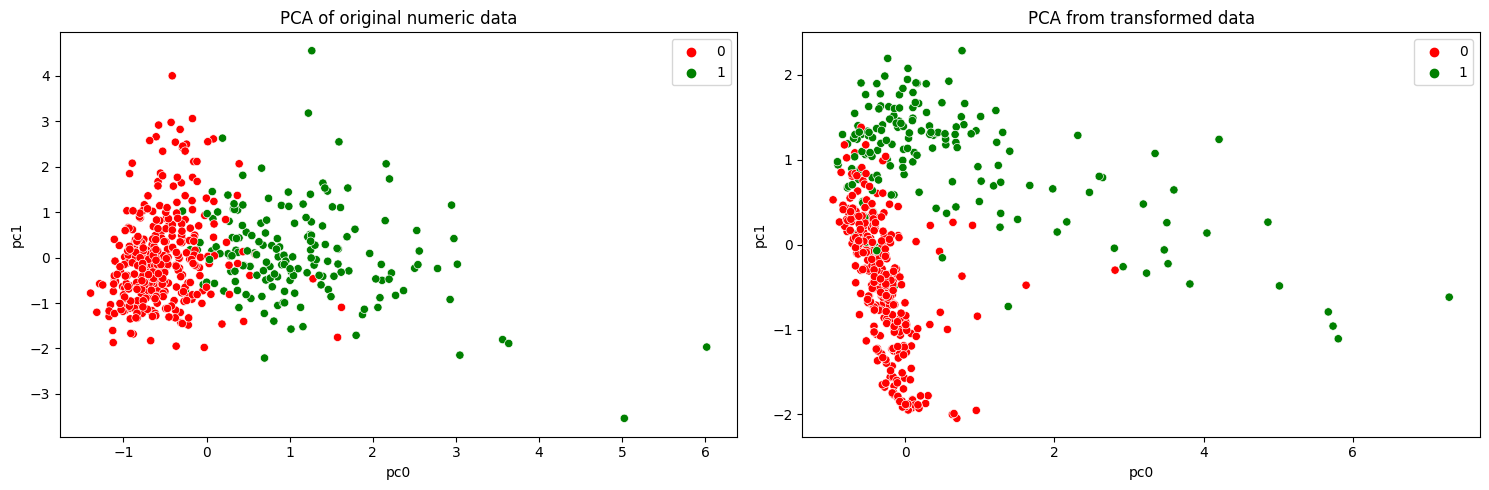

In [ ]:
# 8.0 2D PCA plot from original train data:

plt.style.use("default")
fig = plt.figure(figsize = (15,5));
fig.add_subplot(1,2,1);
sns.scatterplot(data = orig_pca ,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA of original numeric data');

# 8.1 2D PCA plot from transformed train data:

fig.add_subplot(1,2,2);
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA from transformed data') ;

plt.tight_layout();

## xgboost modeling of original data and of transformed data:

In [ ]:
# 9.0 Original train/test data:

evals_result= {}
model_orig = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 6,
                               subsample = 0.8,
                               evals_result = evals_result,
                               random_state = None,
                              )


tr_X =   orig_train[best_features]
test_X = orig_test[best_features]
ytr = ytr
yte = yte


model_orig.fit(tr_X, ytr.values,
               early_stopping_rounds = 50,
               eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
               eval_metric = ['auc']
              )



[09:06:19] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[09:06:19] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[09:06:19] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation_0-auc:0.98276	validation_1-auc:0.97778
[09:06:19] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation_0-auc:0.98624	validation_1-auc:0.98889
[09:06:19] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.98635	validation_1-auc:0.98889
[09:06:19] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[3]	validation_0-auc:0.98705	validation_1-auc:0.98889
[09:06:19] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[4]	validation_0-auc:0.99239	validation_1-auc:0.98788
[09:06:19] INFO

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# 9.1 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"
print("\n===========\n")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"

'Best auc from orig train/test data: 0.9939393939393939'

'Best iteration from orig train/test data: 41'

In [ ]:
# 9.2 Modeling with transformed train/test data:

evals_result= {}
model_trans = xgb.XGBClassifier( n_estimators= 80,
                           verbosity = 3,
                           eta = 0.06,
                           max_depth = 6,
                           subsample = 0.8,
                           evals_result = evals_result,
                           random_state = None,
                           )


tr_X =   train_trans.iloc[:,len(cat_cols):]
test_X = test_trans.iloc[:,len(cat_cols):]
ytr = ytr
yte = yte


model_trans.fit(tr_X, ytr.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']
          )



[09:06:20] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[09:06:20] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[09:06:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation_0-auc:0.98176	validation_1-auc:0.96667
[09:06:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.99185	validation_1-auc:0.98889
[09:06:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.99221	validation_1-auc:0.98889
[09:06:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[3]	validation_0-auc:0.99202	validation_1-auc:0.98889
[09:06:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.99193	validation_1-auc:0.98788
[09:06:20] INFO

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=80, n_jobs=None, num_parallel_tree=None, ...)

### Learning curve plots

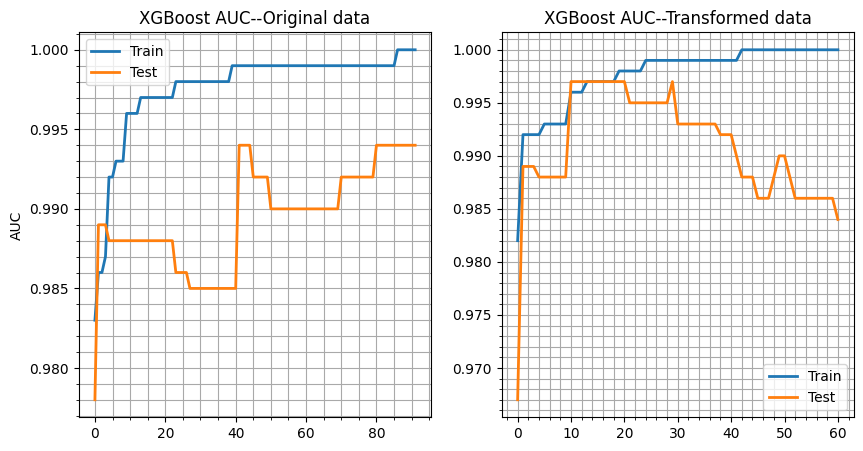

In [ ]:
# 9.3 Modeling with original data:

# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,2, figsize = (10,5));

results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[0].plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
ax[0].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
ax[0].legend();
ax[0].grid(visible = True, which = 'both', color = 'darkgrey')
ax[0].minorticks_on()
ax[0].set_ylabel('AUC');
ax[0].xlabel('no of estimators->')
ax[0].set_title("XGBoost AUC--Original data", fontsize = 10)

# 9.4 Modeling with transformed data:

results = model_trans.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[1].plot(x_axis, np.round(results['validation_0']['auc'],3), linewidth=2, label='Train');
ax[1].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth = 2, label='Test');
ax[1].legend();
ax[1].grid(visible = True, which = 'both', color = 'darkgrey')
ax[1].minorticks_on()
ax[1].xlabel('no of estimators->')
ax[1].set_title('XGBoost AUC--Transformed data', fontsize = 10);
plt.show();

In [ ]:
# 9.5
f"Best auc from transformed train/test data: {model_trans.best_score}"
print("\n===========\n")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"

'Best auc from transformed train/test data: 0.996969696969697'

'Best iteration from transformed train/test data: 10'

## Feature importance from transformed data
Extract feature importance using function `utils.xgImptFeatures()`. The function outputs three objects as follows::
>`fe_1`: List of columns arranged in order of descending xgboost impt(feat-impt >0)<br>
>`fe_0`: List of columns whose xgboost importance is zero<br>
>`fe`: One-column dataframe of feature importance(top-down). Col name is 'imp'<br>

In [ ]:
# 10.0 Get feature importance:
#      fe: Sorted Pandas DataFrame with column name and top-down feature impt

fe_1, fe_0, fe = utils.xgImptFeatures(model_trans,  train_trans.iloc[:,len(cat_cols):].columns)
print("\n=== DataFrame  of impt features top-down =======\n")
fe.iloc[:5]
print("\n\n== Column-list whose feat impt >0 =======\n")
fe_1[:5]  # Arranged in descending order of impt
print("\n\n===Column-list whose feat impt is 0 =======\n")
fe_0[:5]


Order of feature importance is by 'gain'

=== DataFrame  of impt features top-down =======



,imp
eig_concavityMean_ck_textureMean,0.078423
deg_areaSe_ck_textureMean,0.076320
deg_concavityMean_ck_concavityWorst,0.045579
clu_areaMean_ck_areaSe,0.036501
deg_concavityWorst_ck_areaSe_p_textureMean,0.033830




== Column-list whose feat impt >0 =======



['eig_concavityMean_ck_textureMean',
 'deg_areaSe_ck_textureMean',
 'deg_concavityMean_ck_concavityWorst',
 'clu_areaMean_ck_areaSe',
 'deg_concavityWorst_ck_areaSe_p_textureMean']



===Column-list whose feat impt is 0 =======



['bet_areaMean_ck_areaSe_p_concavityMean',
 'eig_concavityMean_ck_textureMean_p_concavityWorst',
 'deg_concavityMean_ck_textureMean_p_concavityWorst',
 'bet_areaSe_ck_concavityWorst',
 'clu_areaSe_ck_concavityWorst']

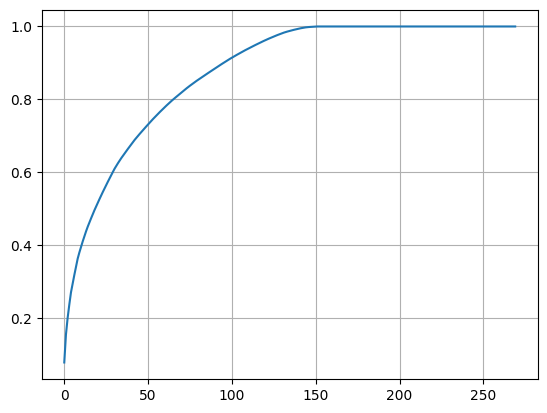

In [ ]:
# 10.1 Cumulative sum of feature importance.
#      Last 100 columns have zero or (near zero)
#      importance:

plt.plot(range(len(fe)), fe['imp'].cumsum().values);
plt.grid();

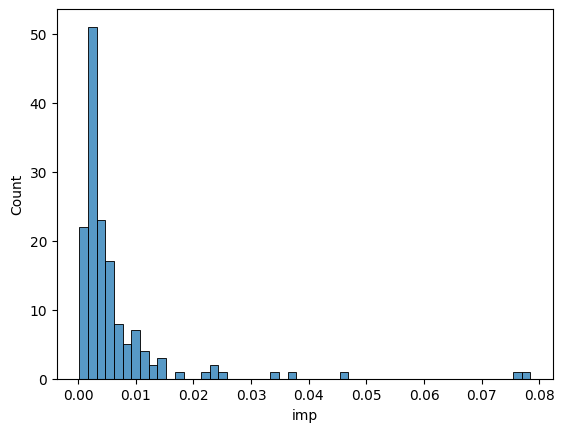

In [ ]:
# 10.2 A histogram plot of feature importance score
#      Most columns have feature impt below 0.01

sns.histplot(fe['imp'][fe_1]);

## Correlation of transformed data with orig features:
Correlation of extracted features with original features

In [ ]:
# 11.0 Take top 5 imp features:

tt = train_trans[fe_1[:5]].copy()
tt.shape  # (513, 5)

(513, 5)

In [ ]:
# 11.1 Reindex orig_train and merge with 'tt':

ot= orig_train[best_features].reset_index(drop = True).copy()
result = ot.merge(tt, left_index = True, right_index=True )


In [ ]:
result.columns

Index(['areaMean', 'areaSe', 'textureMean', 'concavityWorst', 'concavityMean',
       'eig_concavityMean_ck_textureMean', 'deg_areaSe_ck_textureMean',
       'deg_concavityMean_ck_concavityWorst', 'clu_areaMean_ck_areaSe',
       'deg_concavityWorst_ck_areaSe_p_textureMean'],
      dtype='object')

In [ ]:
# 11.2 Try to shorten long column names with shorter ones. We also replace _ck_ by __ :

mapper = {
           'deg_areaSe_ck_textureMean' : 'degArea_se__textureMean',
           'deg_concavityMean_ck_concavityWorst' : 'degConcavityMean__concavityWorst',
           'eig_concavityMean_ck_textureMean' : 'eigConcavityMean__textureMean',
           'deg_concavityWorst_ck_areaSe_p_textureMean' : 'degConcavityWorst__areaSe_p_textureMean',
           'clu_concavityMean_ck_areaSe_p_concavityWorst' : 'cluConcavityMean__areaSe_p_concavityWorst'
}

# 11.3
result = result.rename(columns = mapper)

Correlation heatmap shows good amount of correlation between the two sets of features

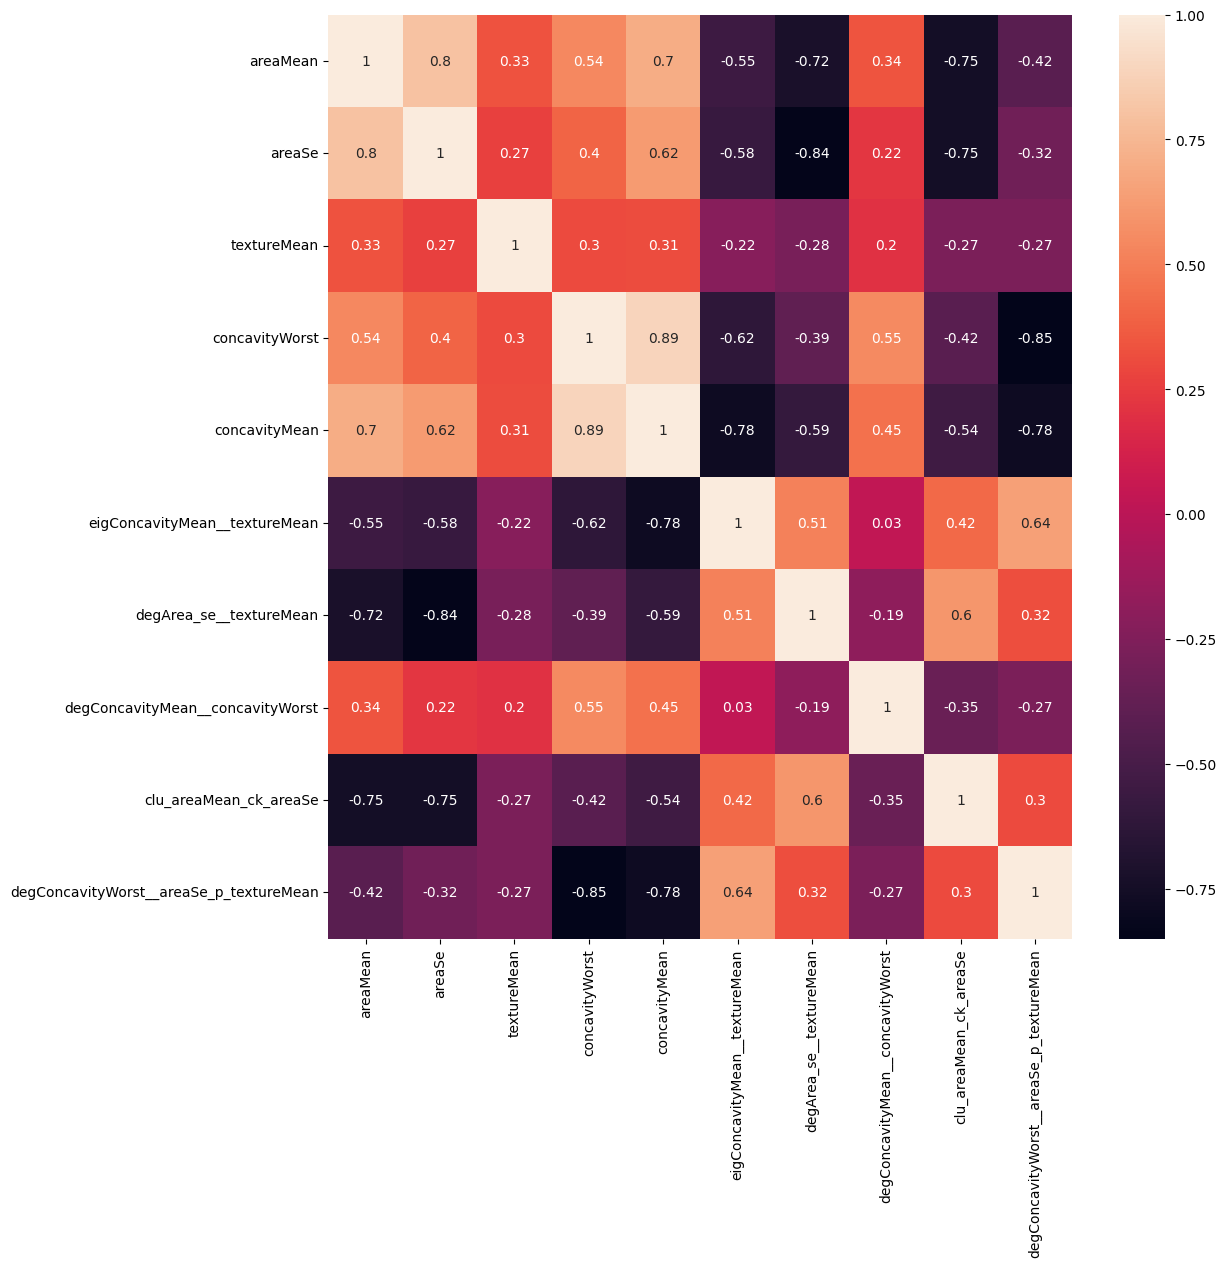

In [ ]:
# 11.4 Correlation heatmap:

plt.figure(figsize = (12,12))
sns.heatmap(np.round(result.corr(),2), annot = True);

## Distribution of transformed features:
Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

eigenvector          0.259259
degree               0.185185
pagerank             0.185185
clusteringcoeff      0.185185
betweenness          0.185185
avgembeddedness      0.000000
leidencomsdensity    0.000000
dtype: float64

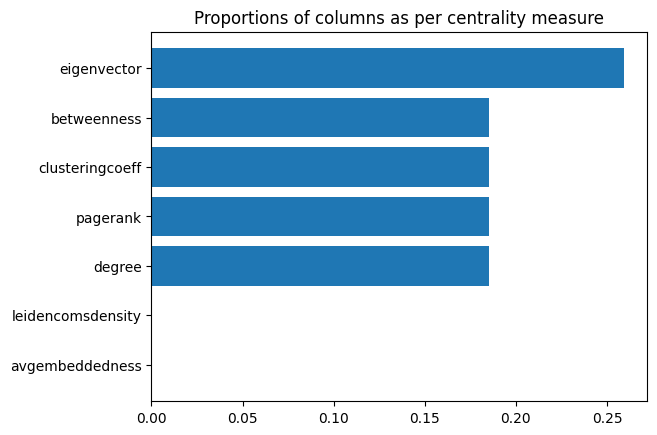

In [ ]:
# 12.0 Our list of columns

colList = (train_trans.iloc[:,len(cat_cols):]).columns

# Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
f
utils.plotSeries(f, "Proportions of columns as per centrality measure")

### Proportions of columns by centrality whose impt is > 0

In [ ]:
# 12.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"


Order of feature importance is by 'gain'


'Columns whose impt is >0: 152'

'Columns whose impt is 0: 118'

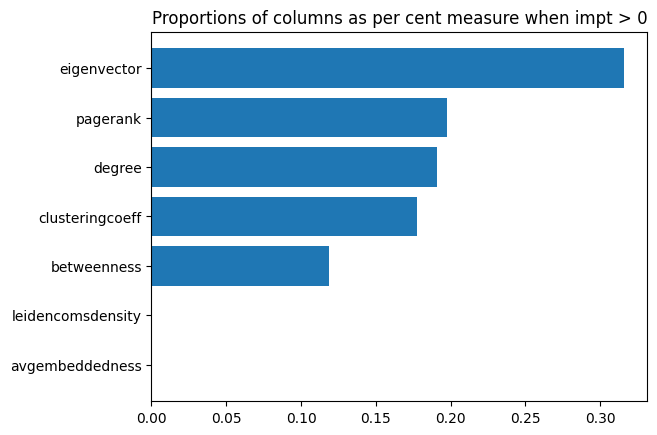

In [ ]:
# 12.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")

### Proportions of columns by summed-up importance score of each centrality measure

In [ ]:
# 13.0 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)



Order of feature importance is by 'gain'


In [ ]:
# 13.1 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 13.2 Score of top-five columns:
score[:5]

eig_concavityMean_ck_textureMean              0.078423
deg_areaSe_ck_textureMean                     0.076320
deg_concavityMean_ck_concavityWorst           0.045579
clu_areaMean_ck_areaSe                        0.036501
deg_concavityWorst_ck_areaSe_p_textureMean    0.033830
Name: imp, dtype: float32

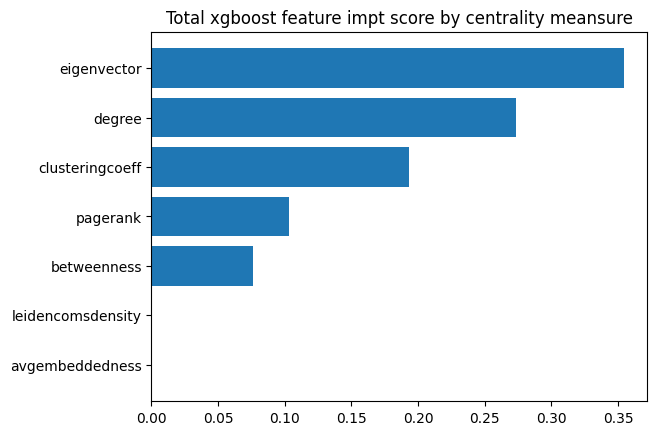

In [ ]:
# 13.3 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Analysing Graphs

### Read graph files from gdrive

In [ ]:
# 16.0 Mount gdrive:

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# 16.1 Path where .gml files are placed:

pathToFolder = Path(graphFolder)
filelist = sorted(list(pathToFolder.iterdir()))
filelist[:5]   # a_bigraph_*

[PosixPath('/gdrive/MyDrive/Colab_data_files/breastcancer/models/areaMean_bigraph_areaMean_p_areaSe.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/breastcancer/models/areaMean_bigraph_areaMean_p_concavityMean.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/breastcancer/models/areaMean_bigraph_areaMean_p_concavityWorst.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/breastcancer/models/areaMean_bigraph_areaMean_p_textureMean.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/breastcancer/models/areaMean_bigraph_areaSe.gml')]

### Read data files from gdrive:

In [ ]:
# 16.1.1
test_binned = pd.read_pickle(dataFolder + "test_binned.pkl")
test_trans = pd.read_pickle(dataFolder + "test_trans.pkl")

# 16.1.2
train_binned = pd.read_pickle(dataFolder + "train_binned.pkl")
train_trans = pd.read_pickle(dataFolder + "train_trans.pkl")

# 16.1.3
orig_test = pd.read_pickle(dataFolder + "orig_test.pkl")
orig_train = pd.read_pickle(dataFolder + "orig_train.pkl")

# 16.1.4
best_features= ["areaMean", "areaSe", "textureMean", "concavityWorst", "concavityMean"]
cat_cols = best_features

# 16.1.5
ct = utils.restorePythonObject("transformer.pkl", dataFolder)

# 16.1.6
y_train = ytr = train_binned['target']
y_test = yte = test_binned["target"]

In [ ]:
# 16.3 check data files:
orig_train.head(2)  # No target
orig_test.head(2)
train_binned.head(2) # Has target
test_binned.head(2)  # Has target
train_trans.head(2)  # No target
test_trans.head(2)   # No target

,areaMean,areaSe,textureMean,concavityWorst,concavityMean
374,1152.0,102.50,18.57,0.3879,0.1323
489,656.9,40.09,21.59,0.3587,0.1293


,areaMean,areaSe,textureMean,concavityWorst,concavityMean
123,1001.0,153.40,10.38,0.7119,0.3001
381,1326.0,74.08,17.77,0.2416,0.0869


,areaMean,areaSe,textureMean,concavityWorst,concavityMean,target
374,413,86,129,1610,2010,1
489,47,82,1213,169,2010,1


,areaMean,areaSe,textureMean,concavityWorst,concavityMean,target
123,411,89,121,1618,2022,1
381,416,84,129,166,207,1


,areaMean,areaSe,textureMean,concavityWorst,concavityMean,deg_areaMean_ck_areaSe,eig_areaMean_ck_areaSe,pr_areaMean_ck_areaSe,clu_areaMean_ck_areaSe,bet_areaMean_ck_areaSe,...,eig_concavityMean_ck_areaSe_p_concavityWorst,pr_concavityMean_ck_areaSe_p_concavityWorst,clu_concavityMean_ck_areaSe_p_concavityWorst,bet_concavityMean_ck_areaSe_p_concavityWorst,eig_concavityMean_ck_areaSe_p_concavityMean,deg_concavityMean_ck_areaMean_p_areaSe,eig_concavityMean_ck_areaMean_p_areaSe,pr_concavityMean_ck_areaMean_p_areaSe,clu_concavityMean_ck_areaMean_p_areaSe,bet_concavityMean_ck_areaMean_p_areaSe
0,413,86,129,1610,2010,0.791667,0.261167,0.055585,0.719298,0.036874,...,0.268714,0.04913,0.785714,0.021792,-0.241972,0.535714,0.216064,0.040763,0.847619,0.005893
1,47,82,1213,169,2010,0.666667,0.239339,0.046617,0.875000,0.010891,...,0.268714,0.04913,0.785714,0.021792,-0.241972,0.535714,0.216064,0.040763,0.847619,0.005893


,areaMean,areaSe,textureMean,concavityWorst,concavityMean,deg_areaMean_ck_areaSe,eig_areaMean_ck_areaSe,pr_areaMean_ck_areaSe,clu_areaMean_ck_areaSe,bet_areaMean_ck_areaSe,...,eig_concavityMean_ck_areaSe_p_concavityWorst,pr_concavityMean_ck_areaSe_p_concavityWorst,clu_concavityMean_ck_areaSe_p_concavityWorst,bet_concavityMean_ck_areaSe_p_concavityWorst,eig_concavityMean_ck_areaSe_p_concavityMean,deg_concavityMean_ck_areaMean_p_areaSe,eig_concavityMean_ck_areaMean_p_areaSe,pr_concavityMean_ck_areaMean_p_areaSe,clu_concavityMean_ck_areaMean_p_areaSe,bet_concavityMean_ck_areaMean_p_areaSe
0,411,89,121,1618,2022,0.833333,0.265286,0.059017,0.663158,0.054084,...,-5.551115e-17,0.006276,0.000000,0.000000,0.323769,0.357143,0.155719,0.028551,1.000000,0.000000
1,416,84,129,166,207,0.833333,0.265286,0.059017,0.663158,0.054084,...,3.582522e-01,0.070527,0.560606,0.102215,-0.373793,0.750000,0.261773,0.057620,0.628571,0.071751


### Display graphs--Bigraphs and Projected

In [ ]:
# 17.0 Get sample list of projected and bigraphs:

projected = [str(i).split("/")[-1] for i in filelist if 'areaMean_projected_' in str(i)]

bigraphs = [str(i).split("/")[-1] for i in filelist if 'areaMean_bigraph' in str(i)]
bigraphs = sorted(bigraphs, key=len)
bigraphs[:8]   # bigraph files
print("\n\n====\n")
projected = sorted(projected, key=len)
projected[:8]    # projected graph files

['areaMean_bigraph_areaSe.gml',
 'areaMean_bigraph_textureMean.gml',
 'areaMean_bigraph_concavityMean.gml',
 'areaMean_bigraph_concavityWorst.gml',
 'areaMean_bigraph_areaMean_p_areaSe.gml',
 'areaMean_bigraph_areaSe_p_textureMean.gml',
 'areaMean_bigraph_areaMean_p_textureMean.gml',
 'areaMean_bigraph_areaSe_p_concavityMean.gml']



====



['areaMean_projected_areaSe.gml',
 'areaMean_projected_textureMean.gml',
 'areaMean_projected_concavityMean.gml',
 'areaMean_projected_concavityWorst.gml',
 'areaMean_projected_areaMean_p_areaSe.gml',
 'areaMean_projected_areaSe_p_textureMean.gml',
 'areaMean_projected_areaMean_p_textureMean.gml',
 'areaMean_projected_areaSe_p_concavityMean.gml']

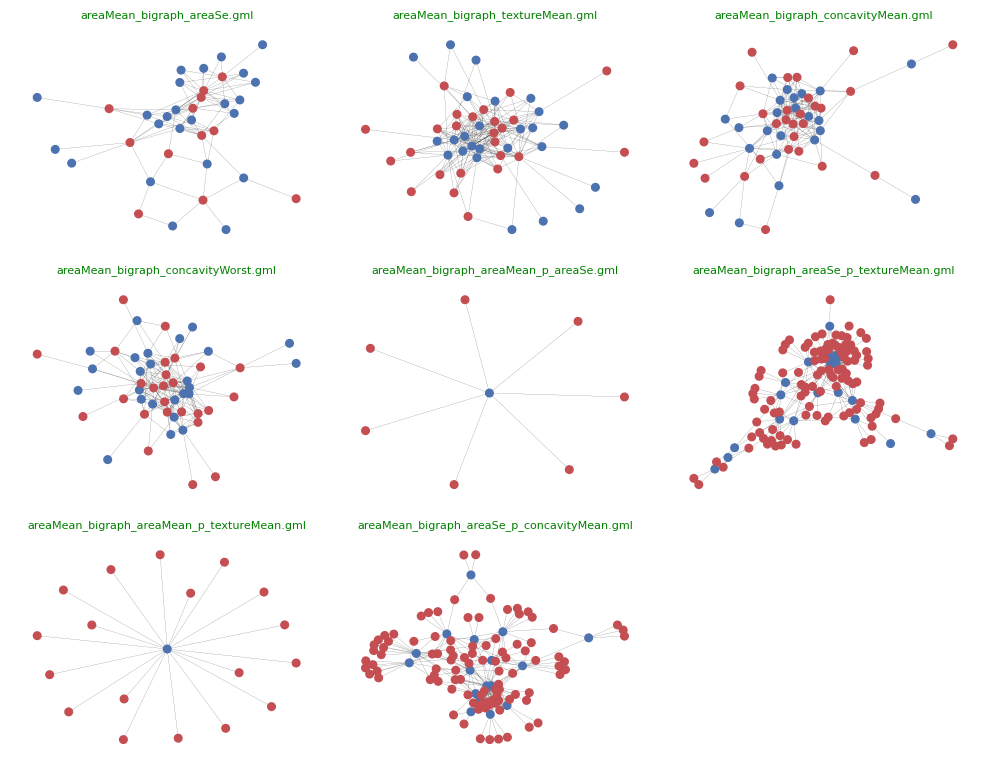

In [ ]:
# 17.1 Plot of sample bigraphs:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(10,18));
for bi in bigraphs[:8]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    # Only show connedted nodes
    _=utils.plotBipartiteGraph(bi,
                               pathToFolder,
                               ax = ax,
                               title = bi,
                               connected = True);
    plt.tight_layout();

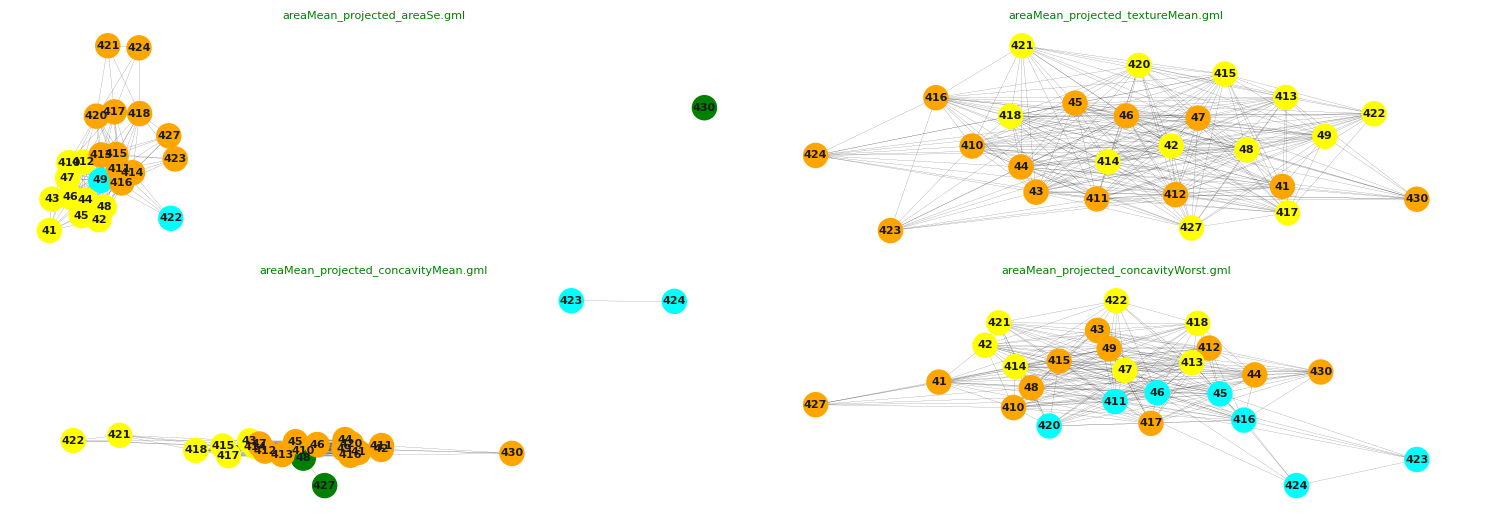

In [ ]:
# 17.2 Plot of sample projected graph files
#      And community visualization within them
#      Modularity class is used to distinguish
#      communities:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:4]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   pathToFolder,
                                   ax = ax,
                                   withLabels = True,
                                   title = prj);
    plt.tight_layout();

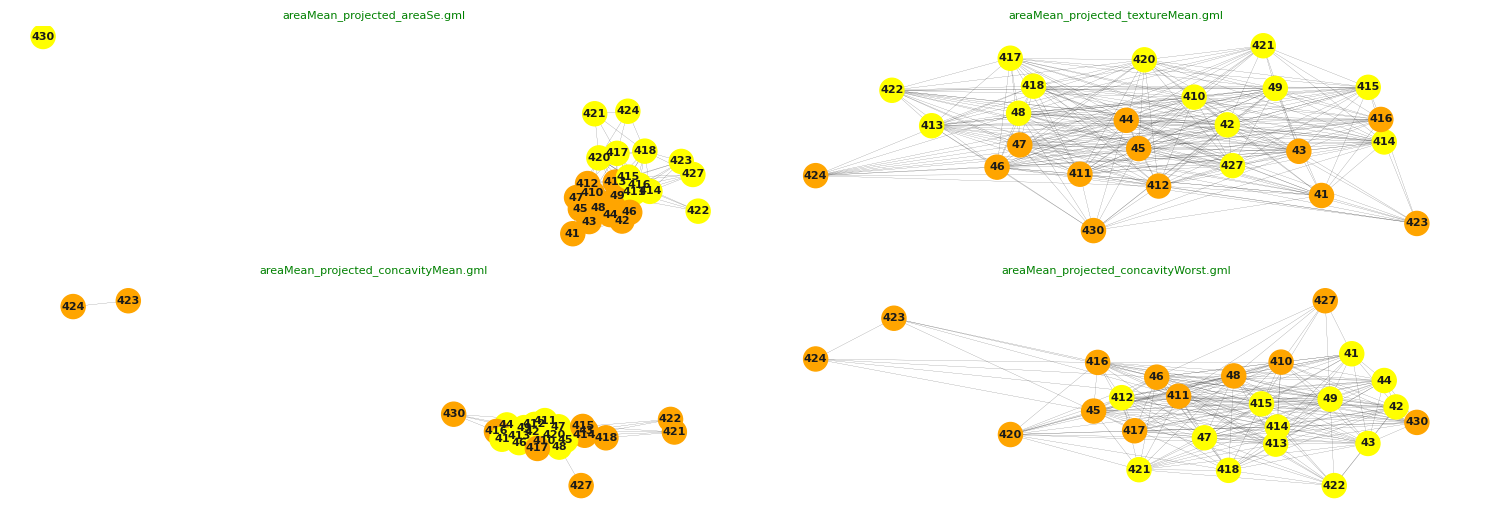

In [ ]:
# 17.2.1 Community visualization using
#        kernighan_lin_bisection algo:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:4]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   pathToFolder,
                                   algo = nx.community.kernighan_lin_bisection,
                                   ax = ax,
                                   withLabels = True,
                                   title = prj);
    plt.tight_layout();

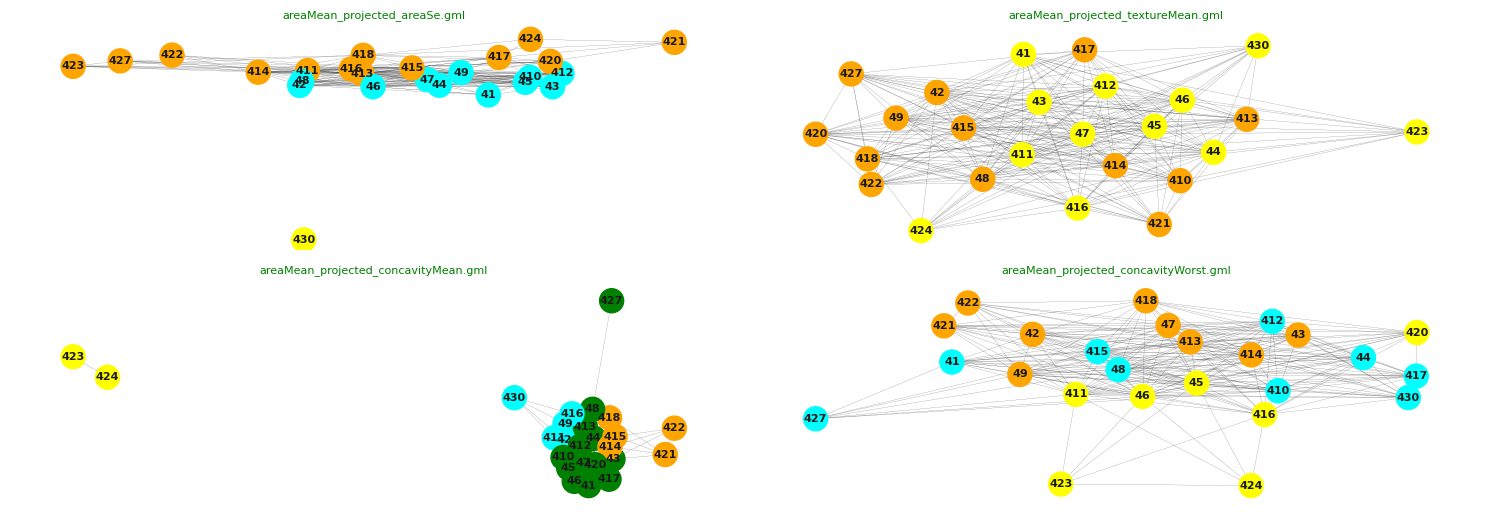

In [ ]:
# 17.2.2 Community visualization using
#        louvain_communities algo:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:4]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,pathToFolder,
                                   algo = nx.community.louvain_communities,
                                   ax = ax,
                                   withLabels = True,
                                   title = prj);
    plt.tight_layout();

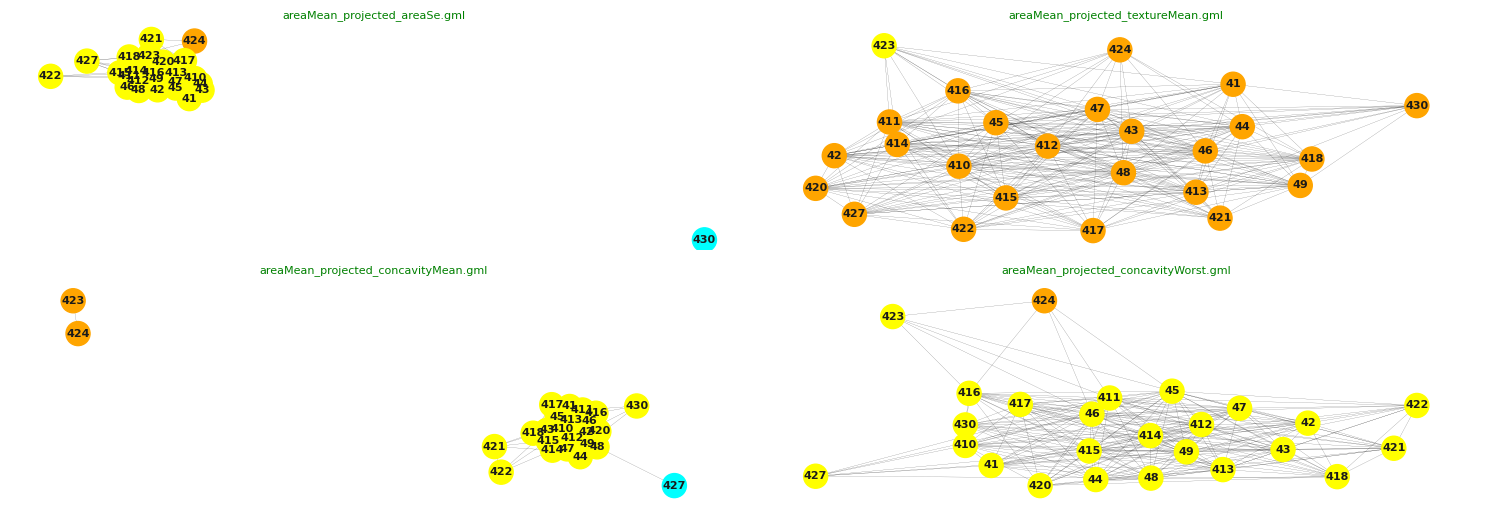

In [ ]:
# 17.2.3 Community visualization using
#        girvan_newman algo:
import itertools
plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:4]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,pathToFolder,
                                   algo = nx.community.girvan_newman,
                                   ax = ax,
                                   withLabels = True,
                                   title = prj);
    plt.tight_layout();

## Transform binned data to communities:

In [ ]:
# 18.0 Transform each column bin as per the community
#       to which it belongs:

# 18.1 Binned cols are:
columnNames = best_features

# 18.2 Communities will be created as per this algo:
algolist = [nx.community.greedy_modularity_communities, nx.community.girvan_newman]


# 18.4 Perform transformation of both train_binned and test_binend:
# 18.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []

# 18.4.2 PErform transformation to community structure
for algo in algolist:
  _,df_tr = utils.transformBinnedDF2Communities(columnNames,
                                                graphFolder,
                                                train_binned,
                                                algo = algo)
  _,df_te = utils.transformBinnedDF2Communities(columnNames,
                                                graphFolder,
                                                test_binned,
                                                algo = algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)

Reading file:  areaMean_projected_areaSe.gml
Reading file:  areaMean_projected_textureMean.gml
Reading file:  areaMean_projected_concavityWorst.gml
Reading file:  areaMean_projected_concavityMean.gml
Reading file:  areaSe_projected_areaMean.gml
Reading file:  areaSe_projected_textureMean.gml
Reading file:  areaSe_projected_concavityWorst.gml
Reading file:  areaSe_projected_concavityMean.gml
Reading file:  textureMean_projected_areaMean.gml
Reading file:  textureMean_projected_areaSe.gml
Reading file:  textureMean_projected_concavityWorst.gml
Reading file:  textureMean_projected_concavityMean.gml
Reading file:  concavityWorst_projected_areaMean.gml
Reading file:  concavityWorst_projected_areaSe.gml
Reading file:  concavityWorst_projected_textureMean.gml
Reading file:  concavityWorst_projected_concavityMean.gml
Reading file:  concavityMean_projected_areaMean.gml
Reading file:  concavityMean_projected_areaSe.gml
Reading file:  concavityMean_projected_textureMean.gml
Reading file:  concavi

In [ ]:
# 18.5 Observe few rows of transformed data:
fg_tr[0].shape   # (513, 20)
fg_tr[0].head(3)
fg_te[0].head(3)


(513, 20)

,areaMean_projected_areaSe.gml,areaMean_projected_textureMean.gml,areaMean_projected_concavityWorst.gml,areaMean_projected_concavityMean.gml,areaSe_projected_areaMean.gml,areaSe_projected_textureMean.gml,areaSe_projected_concavityWorst.gml,areaSe_projected_concavityMean.gml,textureMean_projected_areaMean.gml,textureMean_projected_areaSe.gml,textureMean_projected_concavityWorst.gml,textureMean_projected_concavityMean.gml,concavityWorst_projected_areaMean.gml,concavityWorst_projected_areaSe.gml,concavityWorst_projected_textureMean.gml,concavityWorst_projected_concavityMean.gml,concavityMean_projected_areaMean.gml,concavityMean_projected_areaSe.gml,concavityMean_projected_textureMean.gml,concavityMean_projected_concavityWorst.gml
374,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,3,2
489,1,0,1,0,1,1,0,1,1,1,0,1,0,1,2,1,0,0,3,2
312,1,0,2,0,1,1,0,1,1,0,0,0,1,0,1,1,0,0,0,1


,areaMean_projected_areaSe.gml,areaMean_projected_textureMean.gml,areaMean_projected_concavityWorst.gml,areaMean_projected_concavityMean.gml,areaSe_projected_areaMean.gml,areaSe_projected_textureMean.gml,areaSe_projected_concavityWorst.gml,areaSe_projected_concavityMean.gml,textureMean_projected_areaMean.gml,textureMean_projected_areaSe.gml,textureMean_projected_concavityWorst.gml,textureMean_projected_concavityMean.gml,concavityWorst_projected_areaMean.gml,concavityWorst_projected_areaSe.gml,concavityWorst_projected_textureMean.gml,concavityWorst_projected_concavityMean.gml,concavityMean_projected_areaMean.gml,concavityMean_projected_areaSe.gml,concavityMean_projected_textureMean.gml,concavityMean_projected_concavityWorst.gml
123,0,0,2,0,0,0,0,1,1,0,0,0,1.0,0.0,0.0,2.0,0,0,1,0
381,0,0,2,0,1,0,0,0,0,1,0,0,1.0,1.0,1.0,1.0,0,0,1,1
174,0,1,1,1,0,0,0,0,1,1,0,0,1.0,1.0,1.0,0.0,0,0,0,0


In [ ]:
# 18.5.1 Observe few rows of transformed data:
fg_tr[1].shape   # (513, 20)
fg_tr[1].head(3)
fg_te[1].head(3)


(513, 20)

,areaMean_projected_areaSe.gml,areaMean_projected_textureMean.gml,areaMean_projected_concavityWorst.gml,areaMean_projected_concavityMean.gml,areaSe_projected_areaMean.gml,areaSe_projected_textureMean.gml,areaSe_projected_concavityWorst.gml,areaSe_projected_concavityMean.gml,textureMean_projected_areaMean.gml,textureMean_projected_areaSe.gml,textureMean_projected_concavityWorst.gml,textureMean_projected_concavityMean.gml,concavityWorst_projected_areaMean.gml,concavityWorst_projected_areaSe.gml,concavityWorst_projected_textureMean.gml,concavityWorst_projected_concavityMean.gml,concavityMean_projected_areaMean.gml,concavityMean_projected_areaSe.gml,concavityMean_projected_textureMean.gml,concavityMean_projected_concavityWorst.gml
374,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
489,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
312,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,areaMean_projected_areaSe.gml,areaMean_projected_textureMean.gml,areaMean_projected_concavityWorst.gml,areaMean_projected_concavityMean.gml,areaSe_projected_areaMean.gml,areaSe_projected_textureMean.gml,areaSe_projected_concavityWorst.gml,areaSe_projected_concavityMean.gml,textureMean_projected_areaMean.gml,textureMean_projected_areaSe.gml,textureMean_projected_concavityWorst.gml,textureMean_projected_concavityMean.gml,concavityWorst_projected_areaMean.gml,concavityWorst_projected_areaSe.gml,concavityWorst_projected_textureMean.gml,concavityWorst_projected_concavityMean.gml,concavityMean_projected_areaMean.gml,concavityMean_projected_areaSe.gml,concavityMean_projected_textureMean.gml,concavityMean_projected_concavityWorst.gml
123,1,0,1,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0
381,1,0,1,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0
174,1,0,1,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0


In [ ]:
# 19.0 Remove constant columns from fg_tr[0]:
fg_tr[0] = utils.remConstColumns(fg_tr[0])
fg_te[0] = fg_te[0][fg_tr[0].columns]

Datashape before processing: (513, 20)
Datashape after processing: (513, 18)


In [ ]:
# 19.0.1 Remove constant columns from fg_tr[1]:
fg_tr[1] = utils.remConstColumns(fg_tr[1])
fg_te[1] = fg_te[1][fg_tr[1].columns]

Datashape before processing: (513, 20)
Datashape after processing: (513, 20)


### Save Community data

In [ ]:
# 19.0.2
utils.savePythonObject(fg_tr, "fg_tr.pkl", dataFolder)
utils.savePythonObject(fg_te,"fg_te.pkl", dataFolder)

Object saved to: /gdrive/MyDrive/Colab_data_files/breastcancer/datafiles/fg_tr.pkl
Object saved to: /gdrive/MyDrive/Colab_data_files/breastcancer/datafiles/fg_te.pkl


### Restore Community data

In [ ]:
# 19.0.3
fg_tr = utils.restorePythonObject("fg_tr.pkl", dataFolder)
fg_te = utils.restorePythonObject("fg_te.pkl", dataFolder)

In [ ]:
# 19.1 Extract target columns:

ytr = y_train = train_binned['target']
yte = y_test = test_binned['target']

### xgboost modeling from community indicators:

In [ ]:
# 19.2 Modeling with transformed train/test data with community indicators:

# As we repeat the process many times:
# Del the earlier result, if exists:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 200,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 14,
                                        subsample = 0.8,
                                        random_state = None,
                                      )


tr_X =   fg_tr[0]
test_X = fg_te[0]
ytr = ytr
yte = yte


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 80,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[09:07:07] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[09:07:07] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.97064	validation_1-auc:0.96869
[09:07:07] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation_0-auc:0.97205	validation_1-auc:0.96869
[09:07:07] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.97240	validation_1-auc:0.96768
[09:07:07] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=9
[3]	validation_0-auc:0.98282	validation_1-auc:0.96768
[09:07:07] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=7
[4]	validation_0-auc:0.98312	validation_1-auc:0.96768
[09:07:07] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_d

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

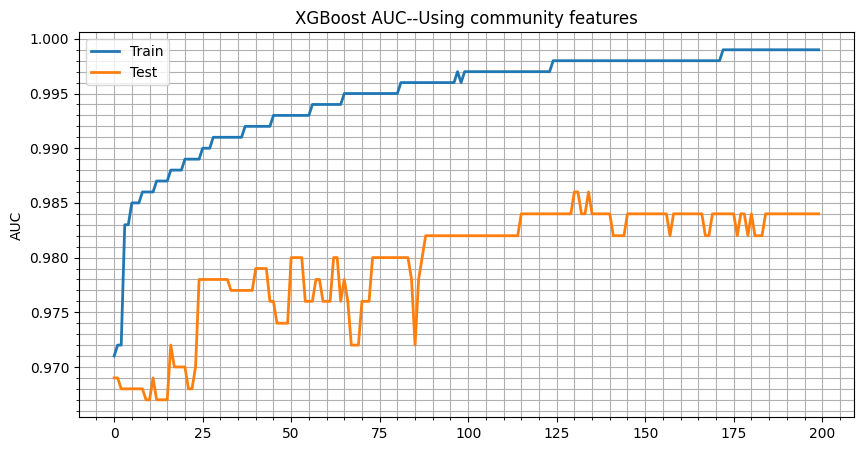

In [ ]:
# 19.3 Modeling with Community data:

# Ref: https://stackoverflow.com/a/60366515
plt.figure(figsize = (10,5));
results = model_trans_commu.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid(visible = True, which = 'both')
plt.minorticks_on()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using community features", fontsize =10);


### PCA using community indicators:

In [ ]:
# 20.0 Impute train data:
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy = "most_frequent")
fg_tr[0][:] = si.fit_transform(fg_tr[0])
fg_tr[0].head(3)

,areaMean_projected_areaSe.gml,areaMean_projected_textureMean.gml,areaMean_projected_concavityWorst.gml,areaMean_projected_concavityMean.gml,areaSe_projected_areaMean.gml,areaSe_projected_textureMean.gml,areaSe_projected_concavityMean.gml,textureMean_projected_areaMean.gml,textureMean_projected_areaSe.gml,textureMean_projected_concavityMean.gml,concavityWorst_projected_areaMean.gml,concavityWorst_projected_areaSe.gml,concavityWorst_projected_textureMean.gml,concavityWorst_projected_concavityMean.gml,concavityMean_projected_areaMean.gml,concavityMean_projected_areaSe.gml,concavityMean_projected_textureMean.gml,concavityMean_projected_concavityWorst.gml
374,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,3,2
489,1,0,1,0,1,1,1,1,1,1,0,1,2,1,0,0,3,2
312,1,0,2,0,1,1,1,1,0,0,1,0,1,1,0,0,0,1


In [ ]:
# 20.1 PCA next:
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
commu_pca = pca.fit_transform(ss.fit_transform(fg_tr[0]))

# 20.2 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(commu_pca.shape[1])]
commu_pca = pd.DataFrame(commu_pca, columns = colnames)

In [ ]:
# https://stackoverflow.com/a/64554001/3282777
# Generate jitter around values by center+random_frac, center-random frac

def jitter(values,center):
    return values + np.random.normal(center,0.2,values.shape)

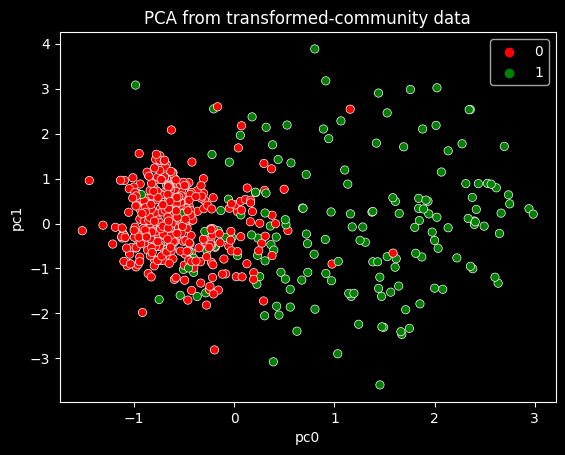

In [ ]:
# 20.3 PCA plot of transformed data:
#      We add some jitter to display
#      overlapping points

plt.style.use("dark_background")
sns.scatterplot(data = commu_pca,
                x=  jitter(commu_pca.pc0, 0),
                y = jitter(commu_pca.pc1, 0),
                hue = ytr.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed-community data') ;

## Derive unit-vectors per level per cat column

In [ ]:
##*****************************
## Embedding Projector
## Incidentally f1-score is highest
##*****************************

### REad data

In [ ]:
# 21.1.1
test_binned = pd.read_pickle(dataFolder + "test_binned.pkl")
test_trans = pd.read_pickle(dataFolder + "test_trans.pkl")

# 21.1.2
train_binned = pd.read_pickle(dataFolder + "train_binned.pkl")
train_trans = pd.read_pickle(dataFolder + "train_trans.pkl")

# 21.1.3
orig_test = pd.read_pickle(dataFolder + "orig_test.pkl")
orig_train = pd.read_pickle(dataFolder + "orig_train.pkl")

# 21.1.4
best_features= ["areaMean", "areaSe", "textureMean", "concavityWorst", "concavityMean"]
cat_cols = best_features

# 21.1.5
y_train = train_binned['target'].reset_index(drop=True)
y_test = test_binned['target'].reset_index(drop = True)

# 21.1.6
ct = utils.restorePythonObject("transformer.pkl", dataFolder)

In [ ]:
# 21.2 Check for nulls:
train_trans.isnull().sum().sum()  # 0
print("---")
test_trans.isnull().sum().sum()   # 54

0

---


54

In [ ]:
# 21.3 Impute test_trans
si = SimpleImputer(strategy = 'median')
si.fit(train_trans)
test_trans[:] = si.transform(test_trans)
# Check
test_trans.isnull().sum().sum()

SimpleImputer(strategy='median')

0

In [ ]:
'target' in list(train_trans.columns)
'target' in list(test_trans.columns)

False

False

In [ ]:
# 21.4 Get target data col.
#      Needed for generation of meta-data file:

test_trans['target'] = y_test
train_trans['target'] =  y_train

In [ ]:
# 22.0 Derive unit vectors:

p = Path(unitvecFolder)
p.mkdir(parents=True, exist_ok=True)

vec_tr,_ = ct.vectorsToTSV(train_trans,
                           take_mean = False,
                           filepath = unitvecFolder,   # Folder where csv files will be saved
                           saveVectorsToDisk = True
                           )

print("\n----test data---\n")

# 22.1 Unit vectors from test data. But not being saved to file:
vec_te,_ = ct.vectorsToTSV(test_trans,
                           take_mean = False,
                           filepath = unitvecFolder,
                           impute = True,
                           saveVectorsToDisk = False
                           )

Checking if vectors exist for all cat cols...
May take time...
Checked for areaMean
Checked for areaSe
Checked for textureMean
Checked for concavityWorst
Checked for concavityMean
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: '/gdrive/MyDrive/Colab_data_files/breastcancer/unitvecfolder/'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature

----test data---

Checking if vectors exist for all cat cols...
May take time...
Checked for areaMean
Checked for areaSe
Checked for textureMean
Checked for concavityWorst
Checked for concavityMean


## Save unit-vectors files to gdrive
Also save output dictionaries for later use

In [ ]:
# 22.2 Save dict to gdrive:

utils.savePythonObject(vec_tr, "vec_tr.pkl", unitvecFolder)
utils.savePythonObject(vec_te, "vec_te.pkl",unitvecFolder)

Object saved to: /gdrive/MyDrive/Colab_data_files/breastcancer/unitvecfolder/vec_tr.pkl
Object saved to: /gdrive/MyDrive/Colab_data_files/breastcancer/unitvecfolder/vec_te.pkl


## Restore unit-vectors files from gdrive

In [ ]:
# 22.3 Restore back:
vec_tr = utils.restorePythonObject( "vec_tr.pkl", unitvecFolder)
vec_te = utils.restorePythonObject("vec_te.pkl",unitvecFolder)

## Using unit vectors to transform train/test data

In [ ]:
# 23.0 USe unit vectors to transform train/test data:

cctr,ccte, vtr,vte = utils.pcaAndConcat(vec_tr, vec_te, n_components = 4)


Performing PCA for areaMean for train data
Performing PCA for areaMean for test data
Performing PCA for areaSe for train data
Performing PCA for areaSe for test data
Performing PCA for textureMean for train data
Performing PCA for textureMean for test data
Performing PCA for concavityWorst for train data
Performing PCA for concavityWorst for test data
Performing PCA for concavityMean for train data
Performing PCA for concavityMean for test data
Concatenating train data
Concatenating test data
Done......


In [ ]:
# 23.1

cctr.head(3)
ccte.head(3)

,pcareaMean0,pcareaMean1,pcareaMean2,pcareaMean3,pcareaSe0,pcareaSe1,pcareaSe2,pcareaSe3,pctextureMean0,pctextureMean1,pctextureMean2,pctextureMean3,pcconcavityWorst0,pcconcavityWorst1,pcconcavityWorst2,pcconcavityWorst3,pcconcavityMean0,pcconcavityMean1,pcconcavityMean2,pcconcavityMean3
0,0.738545,2.956639,-1.156622,0.569796,-0.799510,4.266819,-1.519079,-1.242784,-3.367296,-1.224950,3.568082,2.341167,-2.620813,5.506927,0.090316,-1.139790,-1.927669,4.441485,1.561091,-2.943417
1,-3.607000,-0.811348,1.297891,-0.132892,-6.186994,-0.090493,2.940194,-0.025166,-4.484613,-2.860105,4.025066,-3.332996,-2.421368,4.121971,3.787445,-0.418563,-1.927666,4.441492,1.561095,-2.943420
2,-1.061687,-0.819736,0.398550,-1.458382,-6.186989,-0.090494,2.940200,-0.025176,-2.646317,0.333687,-0.105518,1.161142,2.854864,-6.404197,0.248157,-1.934514,4.967344,-4.758564,-0.969814,2.501730


,pcareaMean0,pcareaMean1,pcareaMean2,pcareaMean3,pcareaSe0,pcareaSe1,pcareaSe2,pcareaSe3,pctextureMean0,pctextureMean1,pctextureMean2,pctextureMean3,pcconcavityWorst0,pcconcavityWorst1,pcconcavityWorst2,pcconcavityWorst3,pcconcavityMean0,pcconcavityMean1,pcconcavityMean2,pcconcavityMean3
0,-3.105385,4.424116,-3.901221,-2.495514,12.170222,8.023536,8.515678,2.584615,20.796177,-1.791669,2.760486,-2.404011,13.784915,3.196414,-1.856593,-0.414672,12.978602,5.610543,-0.910910,-1.784127
1,5.361039,6.702890,-5.343830,0.580365,-6.976077,4.432307,-1.928545,1.160636,-3.367290,-1.224954,3.568082,2.341169,-2.282342,1.370577,0.939674,-0.600457,-3.618776,0.704238,3.173658,2.396105
2,0.527495,6.624908,-5.817652,-0.955536,0.608138,4.223009,-0.612802,-3.841858,-2.232408,-0.983847,-1.230906,-0.655428,-2.551691,3.468227,-0.056580,-1.789916,-1.838738,2.907656,-1.222265,-0.364217


In [ ]:
# 23.2

cctr.shape   #  (513,20)
ccte.shape   #  (56,20)

(513, 20)

(56, 20)

In [ ]:
# 23.3

print(list(cctr.columns[:10]))
print(list(cctr.columns[10:]))


['pcareaMean0', 'pcareaMean1', 'pcareaMean2', 'pcareaMean3', 'pcareaSe0', 'pcareaSe1', 'pcareaSe2', 'pcareaSe3', 'pctextureMean0', 'pctextureMean1']
['pctextureMean2', 'pctextureMean3', 'pcconcavityWorst0', 'pcconcavityWorst1', 'pcconcavityWorst2', 'pcconcavityWorst3', 'pcconcavityMean0', 'pcconcavityMean1', 'pcconcavityMean2', 'pcconcavityMean3']


### Save unitvectors transformed train/test

In [ ]:
# 23.4 Save cctr/ccte to gdrive
cctr.to_pickle(dataFolder + "cctr.pkl")
ccte.to_pickle(dataFolder + "ccte.pkl")

### Readback unitvectors transformed train/test

In [ ]:
# 24.0 Read back cctr/ccte
cctr = pd.read_pickle(dataFolder + "cctr.pkl")
ccte = pd.read_pickle(dataFolder + "ccte.pkl")

# Check
cctr.head(2)
ccte.head(2)
cctr.shape # (513,20)
ccte.shape # (56,20)

,pcareaMean0,pcareaMean1,pcareaMean2,pcareaMean3,pcareaSe0,pcareaSe1,pcareaSe2,pcareaSe3,pctextureMean0,pctextureMean1,pctextureMean2,pctextureMean3,pcconcavityWorst0,pcconcavityWorst1,pcconcavityWorst2,pcconcavityWorst3,pcconcavityMean0,pcconcavityMean1,pcconcavityMean2,pcconcavityMean3
0,0.738545,2.956639,-1.156622,0.569796,-0.799510,4.266819,-1.519079,-1.242784,-3.367296,-1.224950,3.568082,2.341167,-2.620813,5.506927,0.090316,-1.139790,-1.927669,4.441485,1.561091,-2.943417
1,-3.607000,-0.811348,1.297891,-0.132892,-6.186994,-0.090493,2.940194,-0.025166,-4.484613,-2.860105,4.025066,-3.332996,-2.421368,4.121971,3.787445,-0.418563,-1.927666,4.441492,1.561095,-2.943420


,pcareaMean0,pcareaMean1,pcareaMean2,pcareaMean3,pcareaSe0,pcareaSe1,pcareaSe2,pcareaSe3,pctextureMean0,pctextureMean1,pctextureMean2,pctextureMean3,pcconcavityWorst0,pcconcavityWorst1,pcconcavityWorst2,pcconcavityWorst3,pcconcavityMean0,pcconcavityMean1,pcconcavityMean2,pcconcavityMean3
0,-3.105385,4.424116,-3.901221,-2.495514,12.170222,8.023536,8.515678,2.584615,20.796177,-1.791669,2.760486,-2.404011,13.784915,3.196414,-1.856593,-0.414672,12.978602,5.610543,-0.910910,-1.784127
1,5.361039,6.702890,-5.343830,0.580365,-6.976077,4.432307,-1.928545,1.160636,-3.367290,-1.224954,3.568082,2.341169,-2.282342,1.370577,0.939674,-0.600457,-3.618776,0.704238,3.173658,2.396105


(513, 20)

(56, 20)

## xgboost modeling

In [ ]:
# 24.1 Perform xgboost modeling using the above train/test data:

model_vec = xgb.XGBClassifier( n_estimators= 200,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.9,
                              random_state = None,
                              reg_lambda = 1.5,
                           )

## NOTE THIS IS WITHOT resource column
tr_X =    cctr
test_X =  ccte
ytrain =  y_train
ytest = y_test


model_vec.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[09:07:49] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[09:07:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation_0-auc:0.97690	validation_1-auc:0.97778
[09:07:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation_0-auc:0.97904	validation_1-auc:0.97778
[09:07:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.98091	validation_1-auc:0.97778
[09:07:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.98453	validation_1-auc:0.98889
[09:07:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.98488	validation_1-auc:0.98889
[09:07:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_d

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 24.2 Best scores:

model_vec.best_score   # 0.99595959
print("\n")
model_vec.best_iteration  # 17


0.990909090909091

13

In [ ]:
# 24.3 Classification report:

pred_vec = model_vec.predict(test_X)
print(classification_report(ytest,pred_vec))

              precision    recall  f1-score   support

           0       0.52      1.00      0.69        11
           1       1.00      0.78      0.88        45

    accuracy                           0.82        56
   macro avg       0.76      0.89      0.78        56
weighted avg       0.91      0.82      0.84        56



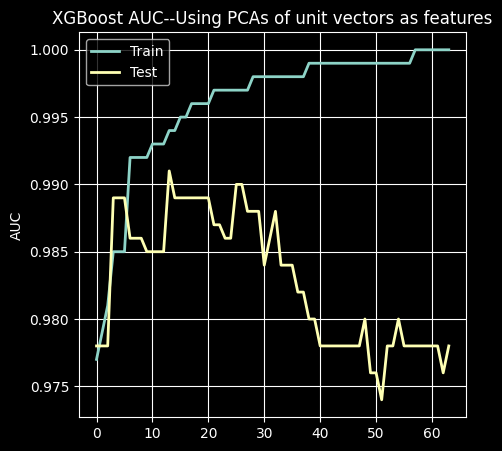

In [ ]:
# 24.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_vec.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using PCAs of unit vectors as features", fontsize= 10);


## Feature Engineering with clustering

In [ ]:
# 25.0 Create clustering features from unitvector dataframes:

n_components = 4  # No of components while performing PCA of every feature
fe_tr,fe_te = utils.featureEngKmeans(cctr,
                                     ccte,
                                     n_clusters = 4,  # No of clusters per feature
                                     step_size = n_components,
                                     km=True,  # Only perform KMeans
                                     gmm=False  # No Gaussian Mixture modeling
                                     )

Current index:  0
Current index:  4
Current index:  8
Current index:  12
Current index:  16


In [ ]:
# 25.1 Output is orig dataframe + clusters
fe_tr.head(3)
fe_te.head(3)

,pcareaMean0,pcareaMean1,pcareaMean2,pcareaMean3,pcareaSe0,pcareaSe1,pcareaSe2,pcareaSe3,pctextureMean0,pctextureMean1,...,pcconcavityWorst3,pcconcavityMean0,pcconcavityMean1,pcconcavityMean2,pcconcavityMean3,clu0,clu1,clu2,clu3,clu4
0,0.738545,2.956639,-1.156622,0.569796,-0.799510,4.266819,-1.519079,-1.242784,-3.367296,-1.224950,...,-1.139790,-1.927669,4.441485,1.561091,-2.943417,0,3,0,3,2
1,-3.607000,-0.811348,1.297891,-0.132892,-6.186994,-0.090493,2.940194,-0.025166,-4.484613,-2.860105,...,-0.418563,-1.927666,4.441492,1.561095,-2.943420,1,0,0,3,2
2,-1.061687,-0.819736,0.398550,-1.458382,-6.186989,-0.090494,2.940200,-0.025176,-2.646317,0.333687,...,-1.934514,4.967344,-4.758564,-0.969814,2.501730,1,0,2,2,0


,pcareaMean0,pcareaMean1,pcareaMean2,pcareaMean3,pcareaSe0,pcareaSe1,pcareaSe2,pcareaSe3,pctextureMean0,pctextureMean1,...,pcconcavityWorst3,pcconcavityMean0,pcconcavityMean1,pcconcavityMean2,pcconcavityMean3,clu0,clu1,clu2,clu3,clu4
0,-3.105385,4.424116,-3.901221,-2.495514,12.170222,8.023536,8.515678,2.584615,20.796177,-1.791669,...,-0.414672,12.978602,5.610543,-0.910910,-1.784127,3,1,1,1,3
1,5.361039,6.702890,-5.343830,0.580365,-6.976077,4.432307,-1.928545,1.160636,-3.367290,-1.224954,...,-0.600457,-3.618776,0.704238,3.173658,2.396105,3,3,0,3,2
2,0.527495,6.624908,-5.817652,-0.955536,0.608138,4.223009,-0.612802,-3.841858,-2.232408,-0.983847,...,-1.789916,-1.838738,2.907656,-1.222265,-0.364217,3,3,2,3,2


In [ ]:
# 25.2 Have a look at clusters created:

fe_tr[fe_tr.columns[-len(cat_cols):]].head()
fe_te[fe_te.columns[-len(cat_cols):]].head()


,clu0,clu1,clu2,clu3,clu4
0,0,3,0,3,2
1,1,0,0,3,2
2,1,0,2,2,0
3,0,2,1,0,0
4,0,0,2,2,0


,clu0,clu1,clu2,clu3,clu4
0,3,1,1,1,3
1,3,3,0,3,2
2,3,3,2,3,2
3,0,0,2,1,3
4,1,3,2,3,2


In [ ]:
# 25.3 Perform xgboost modeling using only the above clusters:

model_fe = xgb.XGBClassifier( n_estimators= 200,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.9,
                              random_state = None,
                              reg_lambda = 1.5,
                           )

tr_X =   fe_tr[fe_tr.columns[-len(cat_cols):]]
test_X =  fe_te[fe_te.columns[-len(cat_cols):]]
ytrain =  y_train
ytest = y_test


model_fe.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[09:08:27] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[09:08:27] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation_0-auc:0.93447	validation_1-auc:0.90808
[09:08:27] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation_0-auc:0.93385	validation_1-auc:0.90808
[09:08:27] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.93393	validation_1-auc:0.90808
[09:08:27] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.93369	validation_1-auc:0.90808
[09:08:27] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.93515	validation_1-auc:0.90808
[09:08:27] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_d

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
model_fe.best_score  # 0.96767676


0.9686868686868687

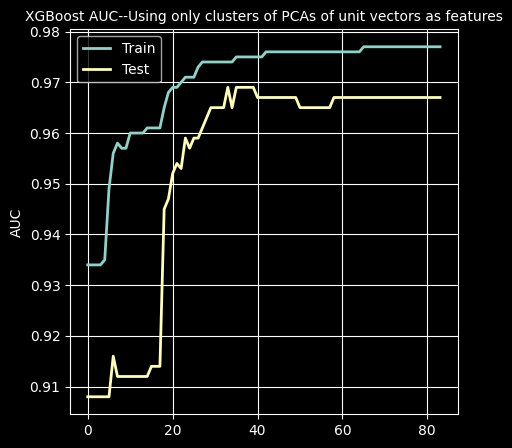

In [ ]:
# 25.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_fe.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using only clusters of PCAs of unit vectors as features", fontsize = 10);


## Averaged unit vectors per level per feature
Unit vectors can be used look at clusters of features in Embedding Projector

In [ ]:
# 26.0
train_trans['target'] = y_train

vec_trx , _ = ct.vectorsToTSV(train_trans,
                           take_mean = True,
                           filepath = unitvecFolder,   # Folder where csv files will be saved
                           saveVectorsToDisk = True,
                           fnamesuffix = "_avg"
                           )

Checking if vectors exist for all cat cols...
May take time...
Checked for areaMean
Checked for areaSe
Checked for textureMean
Checked for concavityWorst
Checked for concavityMean
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: '/gdrive/MyDrive/Colab_data_files/breastcancer/unitvecfolder/'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature


In [ ]:
vec_trx['textureMean'].shape

(25, 54)

A view of Embedding projector for textureMean. One can see around 4-clusters.

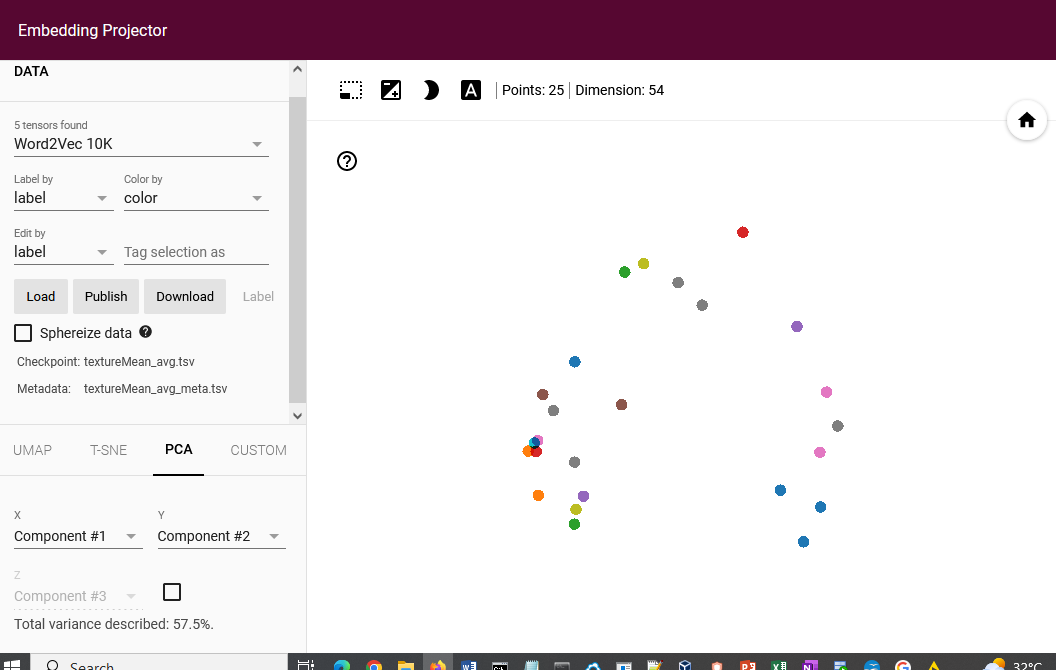

A view of Embedding projector for areaMean. One can see around 3 to 4 clusters.

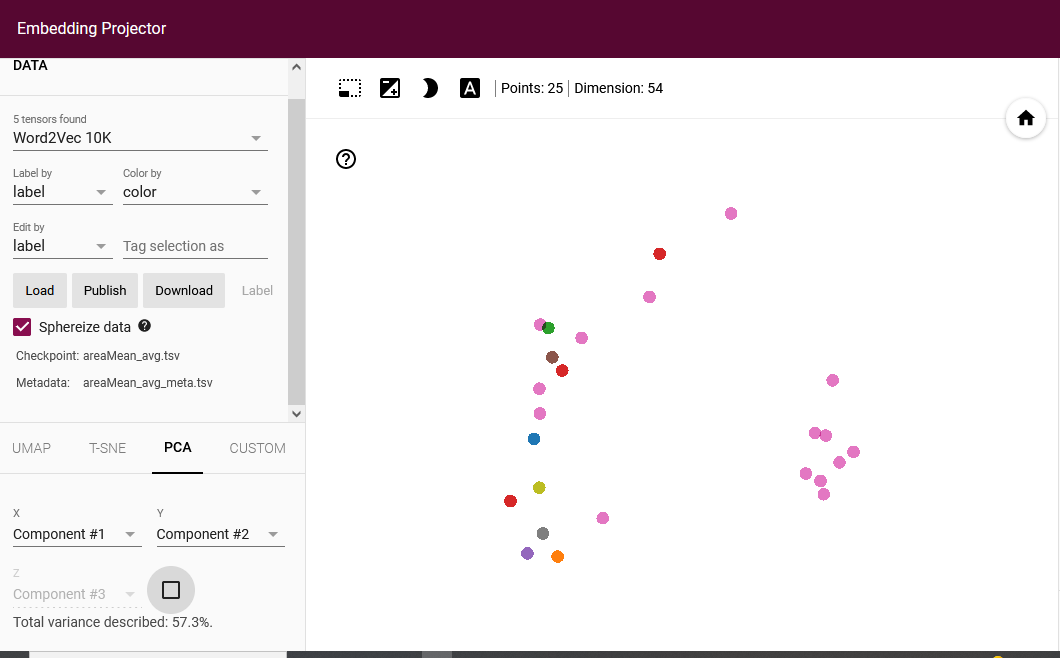

In [ ]:
##################### DONE ####################